#**Load data**

In [ ]:
!pip install findspark
!pip install pyspark

In [69]:
import findspark
from pyspark.sql.types import StructField, StructType, StringType, DoubleType, IntegerType, DateType, ArrayType
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [70]:
def init_spark(app_name: str):
  spark = SparkSession.builder.appName(app_name).getOrCreate()
  sc = spark.sparkContext
  return spark, sc

In [71]:
def load_users(dataPath):
  users_schema = StructType([
                    StructField('user_id', IntegerType(), True),
                    StructField('user_location', StringType(), True)
                    ])

  users = spark.read.format("csv")\
  .option("header","true")\
  .schema(users_schema)\
  .load(dataPath)

  return users

In [72]:
def load_tickets(dataPath):
  tickets_schema = StructType([
                    StructField('user_id', IntegerType(), True),
                    StructField('movie_id', IntegerType(), True),
                    StructField('number_of_tickets', IntegerType(), True),
                    StructField('city', StringType(), True),
                    StructField('cinema_id', IntegerType(), True)
                    ])

  tickets = spark.read.format("csv")\
  .option("header","true")\
  .schema(tickets_schema)\
  .load(dataPath)

  return tickets

In [73]:
def load_credits(dataPath): # Final script after review load credits data
  
  credits_schema = StructType([
                    StructField('cast', StringType(), True),
                    StructField('crew', StringType(), True),
                    StructField('id', IntegerType(), True)
                    ])


  credits = spark.read.option("Header", True)\
  .option("multiline", True)\
  .option("escape", "\"")\
  .csv(dataPath)
  #(option("quote", "\"")) line above solved the missinterputation of the char " by pySpark

  # --- Phase 1: All cells are Strings ---
  
  fix_cols = f.udf(lambda x: x.replace('None', '\'None\''))
  
  credits = credits\
  .withColumn("cast", fix_cols('cast'))\
  .withColumn("crew", fix_cols('crew'))
  
  
  # --- Phase 2: Semi Structured to Structured ---
  schema_cast = ArrayType(
      StructType([StructField("cast_id", StringType(), True), 
                  StructField("character", StringType(), True),
                  StructField("credit_id", StringType(), True), 
                  StructField("gender", StringType(), True),
                  StructField("id", StringType(), True), 
                  StructField("name", StringType(), True),
                  StructField("order", StringType(), True), 
                  StructField("profile_path", StringType(), True)]))

  schema_crew = ArrayType(
      StructType([StructField("credit_id", StringType(), True), 
                  StructField("department", StringType(), True),
                  StructField("gender", StringType(), True), 
                  StructField("id", StringType(), True),
                  StructField("job", StringType(), True), 
                  StructField("name", StringType(), True),
                  StructField("profile_path", StringType(), True)]))

  # changes the columns containing lists of json to structured cells.
  credits = credits.withColumn("cast", f.from_json(credits.cast, schema_cast))\
        .withColumn("crew", f.from_json(credits.crew, schema_crew))

  # --- Phase 3: Extract feilds based on the query data --- 
  extract_name = f.udf(lambda x: ",".join([elem['name'] for elem in x]) if x is not None else "-", StringType())

  # Extract the director's 'name' only
  extract_director_name = f.udf(lambda x: ",".join([elem['name'] for elem in x if elem['job'] == 'Director']) if x is not None else "-", StringType())
  

  credits = credits\
        .withColumn("cast", extract_name('cast'))\
        .withColumn("crew", extract_director_name('crew'))

  # --- Phase 4: Convert Strings representing Arrays to ArrayType(StringType())   
  credits = credits\
        .withColumn("cast", f.split('cast', ','))\
        .withColumn("crew", f.split('crew', ','))
        
  return credits

In [74]:
def load_queries(dataPath): # Final script after review load queries data
  queries_schema = StructType([
                    StructField('user_id', IntegerType(), True),
                    StructField('genres', StringType(), True),
                    StructField('lang', StringType(), True),
                    StructField('actors', StringType(), True),
                    StructField('director', StringType(), True),
                    StructField('cities', StringType(), True),
                    StructField('country', StringType(), True),
                    StructField('from_realese_date', StringType(), True),
                    StructField('production_company', StringType(), True),
                    ])
  queries = spark.read.option("Header", True)\
  .option("multiline", True)\
  .option("escape", "\"")\
  .csv(dataPath)
  #(option("quote", "\"")) line above solved the missinterputation of the char " by pySpark

  # --- Phase 1: All cells are Strings, Clean unwanted chars and prep for conversion to Array---
  clean_for_array = f.udf(lambda x: ",".join([x[1:-1].replace(' ', '').replace('\'', '')]) if x is not None else "-", StringType())
  clean_for_array_cit = f.udf(lambda x: ",".join([x[1:-1].replace(' ', '').replace('\'', '').replace('TelAviv', 'Tel Aviv')]) if x is not None else "-", StringType())

  queries = queries\
        .withColumn("genres", f.split(clean_for_array('genres'), ','))\
        .withColumn("lang", f.split(clean_for_array('lang'), ','))\
        .withColumn("actors", f.split(clean_for_array('actors'), ','))\
        .withColumn("director", f.split(clean_for_array('director'), ','))\
        .withColumn("cities", f.split(clean_for_array_cit('cities'), ','))\
        .withColumn("country", f.split(clean_for_array('country'), ','))\
        .withColumn("from_realese_date", f.split(clean_for_array('from_realese_date'), ','))\
        .withColumn("production_company", f.split(clean_for_array('production_company'), ','))

  # --- Phase 2: Conver Array of String to Array of Integers for the Date Data---
  date_to_int = f.udf(lambda x: [int(x[0])], ArrayType(IntegerType()))

  queries = queries.withColumn("from_realese_date", date_to_int('from_realese_date'))
  return queries


In [75]:
def load_movies(dataPath):  # Final script after review load movies data
  movies_schema = StructType([
                    StructField('movie_id', IntegerType(), False),
                    StructField('genres', StringType(), False),
                    StructField('overview', StringType(), False),
                    StructField('production_companies', StringType(), False),
                    StructField('production_countries', StringType(), False),
                    StructField('release_date', StringType(), False),
                    StructField('revenue', IntegerType(), False),
                    StructField('spoken_languages', StringType(), False),
                    StructField('tagline', StringType(), False),
                    StructField('title', StringType(), False),
                    StructField('cities', StringType(), False)
                    ])
  
  movies = spark.read.option("Header", True)\
  .option("multiline", True)\
  .option("escape", "\"")\
  .csv(dataPath)
  #(option("quote", "\"")) line above solved the missinterputation of the char " by pySpark

  # --- Phase 1: All cells are Strings ---

  # Build structures for empty arrays
  fix_genres = f.udf(lambda x: "[{'id': '-', 'name': '-'}]" if x == '[]' or None else x, StringType()) 
  fix_prod_comp = f.udf(lambda x: "[{'name': '-', 'id': '-'}]" if x == '[]' or None else x, StringType()) 
  fix_prod_coun = f.udf(lambda x: "[{'iso_3166_1': '-', 'name': '-'}]" if x == '[]' or None else x, StringType()) 
  fix_spoken_lang = f.udf(lambda x: "[{'iso_639_1': '-', 'name': '-'}]" if x == '[]' or None else x, StringType()) 
  fix_null_cities = f.udf(lambda x: x[1:-1].replace(' ', '').replace('\'', '').replace('TelAviv', 'Tel Aviv') if x is not None else "[]", StringType()) 
  fix_null_date = f.udf(lambda x: x if x is not None else "00/00/2030", StringType()) # 2030 as none for us. 

  movies = movies\
  .withColumn("genres", fix_genres('genres'))\
  .withColumn("production_companies", fix_prod_comp('production_companies'))\
  .withColumn("production_countries", fix_prod_coun('production_countries'))\
  .withColumn("spoken_languages", fix_spoken_lang('spoken_languages'))\
  .withColumn("release_date", fix_null_date('release_date'))\
  .withColumn("cities", fix_null_cities('cities'))

  
  movies = movies.na.fill('Empty')

  # At this point, all the cells which have another struct in them, will have an empty struct as string, descreption only cells with null- will have 'Empty' instead of null.
  # This is the way we decided to work with the null cells inorder to control the DataFrame and drop any tuples.

  # --- Phase 2: Semi Structured to Structured ---

  schema_genres = ArrayType(
      StructType([StructField("id", StringType(), True), 
                  StructField("name", StringType(), True)]))

  schema_production_company = ArrayType(
      StructType([StructField("name", StringType(), True), 
                  StructField("id", StringType(), True)]))

  schema_production_countries = ArrayType(
      StructType([StructField("iso_3166_1", StringType(), True), 
                  StructField("name", StringType(), True)]))

  schema_spoken_languages = ArrayType(
      StructType([StructField("iso_639_1", StringType(), True), 
                  StructField("name", StringType(), True)]))

  # changes the columns containing lists of json to structured cells. 
  movies = movies.withColumn("genres", f.from_json(movies.genres, schema_genres))\
    .withColumn("production_companies", f.from_json(movies.production_companies, schema_production_company))\
    .withColumn("production_countries", f.from_json(movies.production_countries, schema_production_countries))\
    .withColumn("spoken_languages", f.from_json(movies.spoken_languages, schema_spoken_languages))

  # --- Phase 3: Extract feilds based on the query data --- 

  # Extracts the value of 'name' in each json in the cell of column 
  extract_name = f.udf(lambda x: ",".join([elem['name'] for elem in x]) if x is not None else "-", StringType())
  
  
  #Extracts year from the date format
  extract_year = f.udf(lambda x: int(x[-4:]) if '-' not in x else int(x[:4]), IntegerType())
  
  movies = movies\
        .withColumn("genres", extract_name('genres'))\
        .withColumn("production_companies", extract_name('production_companies'))\
        .withColumn("production_countries", extract_name('production_countries'))\
        .withColumn("spoken_languages", extract_name('spoken_languages'))\
        .withColumn("release_date", extract_year('release_date'))
    
  # --- Phase 4: Convert Strings representing Arrays to ArrayType(StringType()) ---
  
  # converts columns which need to be array types from string containing arrays of strings  
  movies = movies\
        .withColumn("genres", f.split('genres', ','))\
        .withColumn("production_companies", f.split('production_companies', ','))\
        .withColumn("production_countries", f.split('production_countries', ','))\
        .withColumn("spoken_languages", f.split('spoken_languages', ','))\
        .withColumn("cities", f.split('cities', ','))

  return movies

In [76]:
if __name__ == '__main__':
    # Create spark project
    spark, sc = init_spark('project_A')

    # Load Data
    movies = load_movies("movies.csv")
    credits = load_credits("credits.csv")
    users = load_users("users.csv")
    queries = load_queries("queries.csv")
    tickets = load_tickets("tickets.csv")    

#**Insight 1: User locations impact on query cities and ticket buying**

Starting assumption: Users would query regarding movies which are shown in their city. To check this we needed to JOIN users data and the two columns 'user_id' and 'cities' from queries data, (where users.user_id == queries.user_id), Then we'll need to check if the users location is in the cities cell containing an Array of cities queried about.

Note: users living in 'Kibuts Gesher' - closest cinema is 'Tiberias' (25.3 KM vs. Haifa 83.9 KM, Tel-Aviv 133 KM, Jerusalem 146 KM, Eilat 384 KM)

In [77]:
# select both columns from queries
qu = queries.select('user_id', 'cities')

# Inner join basen on user_id
join_df = qu.join(users,queries.user_id == users.user_id,"inner")


# convert user location column to array containing location
join_df = join_df.withColumn('user_location', f.split('user_location', ','))

# Returns 1 for each row if location of user is in the cities in query, 
check_loc_in_cities = f.udf(lambda arr: 1 if arr[0][0] in arr[1] or (arr[0][0] == 'Kibuts Gesher' and 'Tiberias' in arr[1]) else 0, IntegerType())

df = join_df.withColumn("result_check", check_loc_in_cities(f.array('user_location', 'cities')))

print("DF after SELECT, JOIN and creating column containing 1/0:")
df.show(3)
print()

sum_correct = df.agg({'result_check': 'sum'}).collect()[0][0]
num_rows = df.select(f.count("result_check")).collect()[0][0]


DF after SELECT, JOIN and creating column containing 1/0:
+-------+-----------------+-------+-------------+------------+
|user_id|           cities|user_id|user_location|result_check|
+-------+-----------------+-------+-------------+------------+
|    981|[Haifa, Tiberias]|    981|      [Haifa]|           1|
|   3775|       [Tel Aviv]|   3775|   [Tel Aviv]|           1|
|   4095|      [Jerusalem]|   4095|  [Jerusalem]|           1|
+-------+-----------------+-------+-------------+------------+
only showing top 3 rows




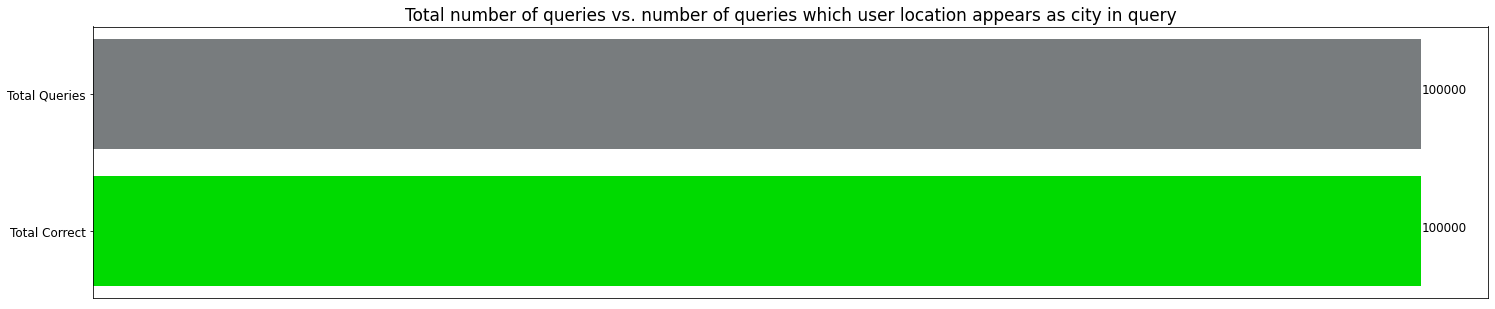

In [78]:
plt.figure(figsize=(25, 5))
y = ['Total Correct', 'Total Queries']
x = [sum_correct, num_rows]

plt.barh(y, x, color=['#00DA00', '#787C7E'])
plt.yticks(fontsize=12)
plt.title("Total number of queries vs. number of queries which user location appears as city in query", fontsize=17)
plt.text(num_rows + 5, 0, str(num_rows), color='black', fontsize=12)
plt.text(sum_correct + 5, 1, str(sum_correct), color='black', fontsize=12)
plt.xticks([])
plt.show()

<center>figure 1.1. 100% of users use their location in the query for cities which the movie is played at.


This approved our assumption, but was only an insight on the users query behaviour. We decided to check if we could clearly say there are cities users from certain cities **DONT** query about at all.


In [79]:
# select both columns from queries
qu = queries.select('user_id', 'cities')

# Inner join basen on user_id
join_df = qu.join(users,queries.user_id == users.user_id,"inner")

# Group by user location and create list of all the cities queried from that location
grouped_by_df = join_df.groupBy("user_location").agg(f.collect_list("cities"))

# Flatten the Array of Arrays
df = grouped_by_df.select("user_location",f.flatten("collect_list(cities)"))
df = df.select("user_location", f.array_distinct(df['flatten(collect_list(cities))']))

# Show results
res = df.collect()
cities = {'Tiberias', 'Haifa', 'Tel Aviv','Jerusalem', 'Eilat'}
cities_list = ['Tiberias', 'Haifa', 'Tel Aviv', 'Jerusalem', 'Eilat']

data_plot = []

for row in res:
  # subtract sets and clean for print
  not_cities_set = cities - set(row[1])
  not_cities_str = str(not_cities_set).replace("'", "").replace("{", "").replace("}", "")

  temp_res = [0 if x in list(not_cities_set) else 1 for x in cities_list]
  data_plot.append(temp_res)
  print(f'Users in {row[0]} NEVER query regarding movies in: {not_cities_str}')

Users in Kibuts Gesher NEVER query regarding movies in: Eilat, Tel Aviv, Jerusalem
Users in Haifa NEVER query regarding movies in: Eilat, Jerusalem
Users in Jerusalem NEVER query regarding movies in: Haifa, Eilat, Tiberias
Users in Tel Aviv NEVER query regarding movies in: Haifa, Eilat, Tiberias
Users in Eilat NEVER query regarding movies in: Haifa, Tel Aviv, Tiberias, Jerusalem


We can see that each location has cities they will never query about. Eilat are the most extreme, with all users located in eilat - never mentioning other cities in their queries.

This user-behavior will contribute to the fragmentation in Q3. 
For example, Jerusalems movie data stored on their site, can be horizontally divided into 2 fragments, one in which the cities are mentioned in queries by users located in Jerusalem and one which the cities are not mentioned (Haifa, Eilat, Tiberias)

*See figure 1.2 for visualization.*

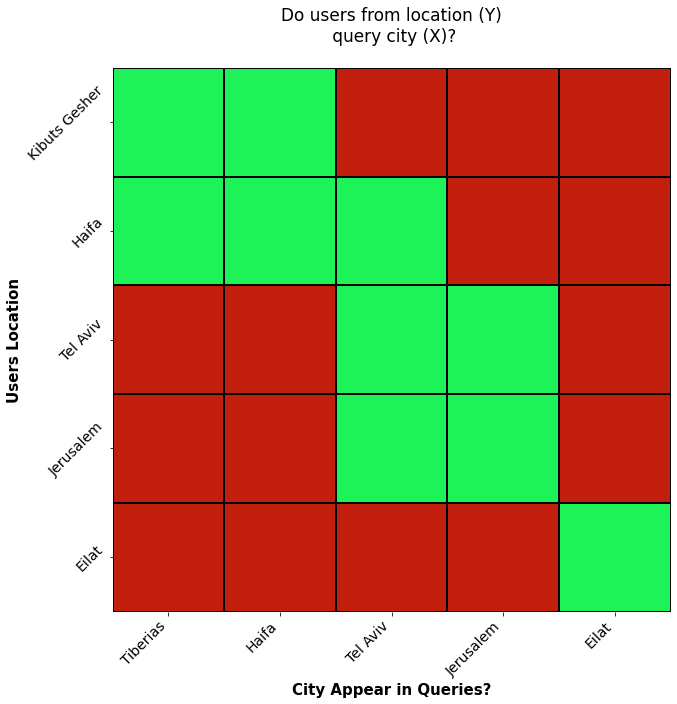

In [80]:
# plot visualization
np_array = np.array(data_plot)
df_plt = pd.DataFrame(np_array, columns=['Tiberias', 'Haifa', 'Tel Aviv', 'Jerusalem', 'Eilat'])
plt.figure(figsize=(10,10))
yticks = ['Kibuts Gesher', 'Haifa', 'Tel Aviv', 'Jerusalem', 'Eilat']
g = sns.heatmap(df_plt, linewidths=1, linecolor='black', yticklabels=yticks, cbar=False, cmap= ['#C11E0E', '#1EF257'])
plt.title('Do users from location (Y)\n query city (X)?\n', fontsize=17)
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right', fontsize=14)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=14)
plt.ylabel('Users Location', fontsize=15, fontweight='bold')
plt.xlabel('City Appear in Queries?', fontsize=15, fontweight='bold')

plt.show()


<center>figure 1.2, green/red: city appears/dosnt appear in queries of users from rows location


To conclude, we wanted to know if the query behaviour is reflected in the tickets data. Meaning, If we found that users from Eilat, only query movies showed in Eilat, **do they only purchase tickets in Eilat**?



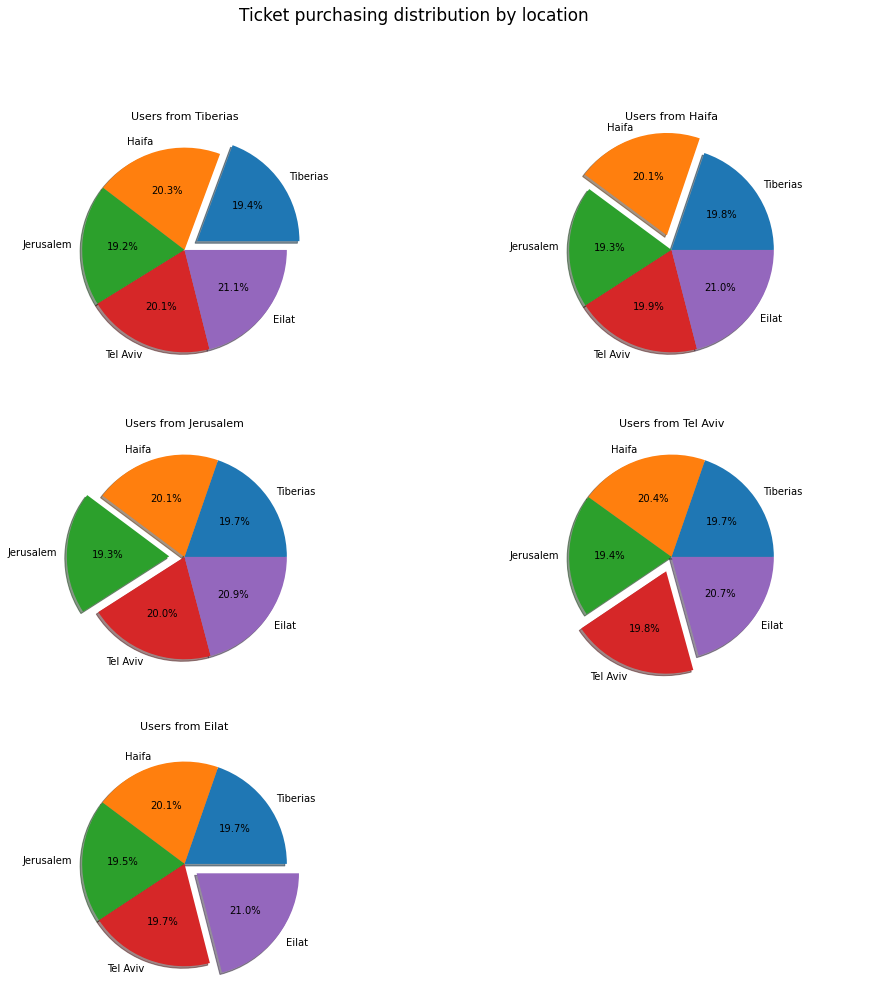

In [81]:
df = tickets.select('user_id', 'city', 'number_of_tickets' )
# Inner join with users data basen on user Id
df = df.join(users,df.user_id == users.user_id,"inner")

location_collect=[]
city = ["Tiberias", "Haifa", "Jerusalem", "Tel Aviv", "Eilat"]
locations = ["Kibuts Gesher", "Haifa", "Jerusalem", "Tel Aviv", "Eilat"]

zero = (5,5)
total = np.zeros(5)
counter= np.zeros(zero)
precentage = np.zeros(zero)


# for each city, we want to know how the ticket purchasing is distributed per location
for c in locations:
  dfs = df.filter(df['user_location'] == c)
  location_collect.append(dfs.collect())

# define a counter: user from Gesher buy tickets for movie in Gesher, Haifa, Jerusalem, Tel Aviv and Eilat
# multiply the num of tickets in every buy ???? is there supposed to be a multiplication?

for ind, col in enumerate(location_collect):
  for user in col:
    for index, loc in enumerate(city):
      if user[1]==loc:    
          counter[ind][index]+=user[2]
          total[ind]+=user[2]

# precentage table of counter table
for i, row in enumerate(counter):
  for j, col in enumerate(row):
    precentage[i][j] = col/total[i]

# Plot figures
explodes= np.identity(5)*0.15
fig, axes = plt.subplots(3,2,figsize=(16,16))
fig.suptitle(f'Ticket purchasing distribution by location', fontsize= 17)
i = 0
for row_i in range(2):
  for col_i in range(2):
    axes[row_i, col_i].pie(precentage[i], labels=city, autopct='%1.1f%%', explode=explodes[i], shadow=True)
    axes[row_i, col_i].set_title(f'Users from {city[i]}', fontsize= 11, pad=1.5)
    i +=1

axes[2, 0].pie(precentage[4], labels=city, autopct='%1.1f%%', explode=explodes[4], shadow=True)
axes[2, 0].set_title(f'Users from {city[4]}', fontsize= 11)
axes[2, 1].axis('off')

plt.show()

<center>figure 1.3. Pie plot of tickets purchased by location per city (%)


From looking at figure 1.3 above, clearly we can conclude that theres no connection between the location of a user to their ticket purchasing habits regarding the cities they buy tickets from. Furthermore, the distribution of each city to purchase tickets from other cities is uniformly distributed among the other cities (~20% per city for every location). 



##**Insight 1 conclusion**

To conclude insight 1, our assumption which was that theres some connection between users location to the cities they query was found to be correct and will contribute to the distribution of the data base. Unfortunetley, this behaviour was not proven to be correct when it came to the purchasing of tickets depending on the location of users. 

This might occur due to the partially sinthetic data we are working with. 
In reality, it is likely people purchase tickets in cinemas depending on their location and in some sort of connection to the queries they make representing their research prior to purchasing a ticket. *italicized text*

#**Insight 2: Users movie release_date preference by location**

Question: Do users query the data base regarding all the movies in the movies data?

Movies release date is a great indicator to check whether theres movies never queried about. We came to this assumption seeing that EVERY query has a 'from_release_date' value.

To check this we needed to JOIN users data and the two columns 'user_id' and 'from_realese_date' from queries data, (where users.user_id == queries.user_id), then we used GroupBy on users location with an aggregation to find min value.

In [82]:
# Created new table based on 2 columns from query data
df = queries.select('user_id', 'from_realese_date')
# Inner join basen on user Id
df = df.join(users,df.user_id == users.user_id,"inner")

# Extract year int from the Arrays of Integers
extract_year_udf = f.udf(lambda x: x[0], IntegerType())

df = df.withColumn('date_int', extract_year_udf('from_realese_date'))

df = df.groupBy("user_location").min('date_int')
df = df.withColumnRenamed('min(date_int)', 'Min release date for movies queried')

df.show()

+-------------+-----------------------------------+
|user_location|Min release date for movies queried|
+-------------+-----------------------------------+
|Kibuts Gesher|                               1990|
|        Haifa|                               2010|
|    Jerusalem|                               1990|
|     Tel Aviv|                               2010|
|        Eilat|                               1990|
+-------------+-----------------------------------+



<center>figure 2.1

This made us ask,  whats the minimum release date in the movies data?

In [83]:
min_movie = movies.agg({'release_date': 'min'})
min_movie.show()

min_year = df.collect()[0][0]

filter = movies.filter(movies['release_date'] == min_year).select('title').collect()
for mov in filter:
  print(f'Title of movie released in {min_year}: "{mov[0]}"')


+-----------------+
|min(release_date)|
+-----------------+
|             1874|
+-----------------+



Wouldnt have guessed that there were movies released in 1874.

For curious readers: https://youtu.be/LowU9vKZzJs (enjoy)

This made us check how many movies in the data do users by location not query about? 

<Figure size 720x720 with 0 Axes>

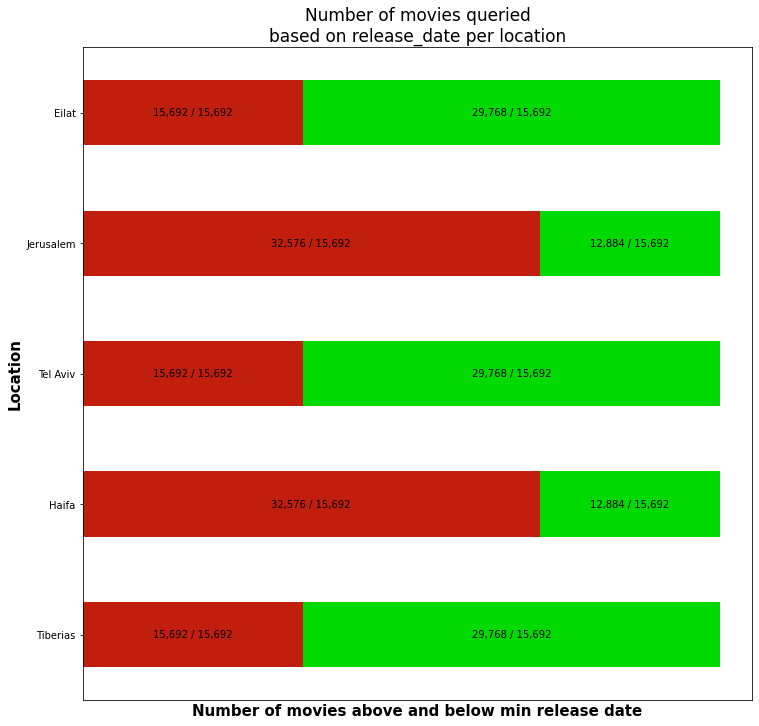

In [84]:
data = df.collect()

count_prior = {}

for row in data:
  loc = row[0]
  earliest = row[1]
  filter = movies.filter(movies['release_date'] < earliest)
  num_movies_prior = filter.select(f.count("release_date")).collect()[0][0]
  count_prior[loc] = num_movies_prior

total_movies = movies.select(f.count("movie_id")).collect()[0][0]

not_q = [count_prior[key] for key in count_prior]
yes_q = [total_movies - x for x in not_q]
plot_data = {'Location': ['Tiberias', 'Haifa', 'Tel Aviv', 'Jerusalem', 'Eilat'], 'not_q': not_q, 'yes_q': yes_q}

plt.figure(figsize=(10,10))
df_ = pd.DataFrame(plot_data)
df_.plot(x ='Location', kind = 'barh', stacked = True, mark_right = True, legend=False, color= ['#C11E0E' ,'#00DA00'], figsize=(12, 12))

df_total = df_["not_q"] + df_["yes_q"]
df_rel = df_[df_.columns[1:]]

for n in df_rel:
    for i, (cs, ab, val) in enumerate(zip(df_.iloc[:, 1:].cumsum(1)[n], df_[n], df_rel[n])):
        plt.text(cs - ab / 2, i, "{:,}".format(val) + ' / ' + "{:,}".format(num_movies_prior), va = 'center', ha = 'center')

plt.xlabel('Number of movies above and below min release date', fontsize=15, fontweight='bold')
plt.ylabel('Location', fontsize=15, fontweight='bold')
plt.title('Number of movies queried\nbased on release_date per location', fontsize=17)
plt.xticks([])
plt.show()



<center> figure 2.2, amount of movies which are in or out (green / red) of range, based on minimum release date per location found in fig 2.1. Example: Haifa, minimum release date query from figure 2.1 is 2010, from figure 2.2 we see there are 32,576 movies released before 2010 and 12,884 movies released after 2010 in the data.

##**Insight 2 conclusion**

By finding the minimum release date of movies each location query and counting the number of movies outside this range in the movies data, we have found that many movies are never queried.

This will contribute to the distribution design in next question.


#**Insight 3: Genre preference distribution dependent by location**


Assumption: Generes prefrence based on the location of a user.

For instance, French is known as the language of love and romance, do netflix users in france watch more romantic movies than users from the U.S?

Our data is only from Israel, but its worth looking into the question, do users from certain locations have a preferred genre?

To check this we needed to JOIN users data and the two columns 'user_id' and 'genres' from queries data, (where users.user_id == queries.user_id), then we used GroupBy on location to find all the generes searched by location. We counted the occurance of each genre and used simple bar plots to visualize the findings. 

In [101]:
df = movies.select('genres')

# creating list of all the unique genres in the data
df = df.withColumn("group_column", f.lit(1))
df = df.groupBy("group_column").agg(f.collect_list("genres"))
genres = df.withColumn("all_genres", f.flatten("collect_list(genres)")).select('all_genres')

genres_set = set(genres.collect()[0][0])
genres_set.remove('-')  # '-' represents a cell without genre value given (in movies)
print(f'Number of unique genres: {len(genres_set)}')


def counter_list(val_list):
  # counts occurence of value in list, could have implemented with explode and groupe by using spark, but was very bad runtime. 
  return_dict = {}
  for val in val_list:
    if val in return_dict:
      return_dict[val] += 1
    else:
      return_dict[val] = 1
  sort_dict = [(key, return_dict[key]) for key in return_dict]
  sort_dict.sort(key= lambda x: x[1], reverse= True)

  return dict(sort_dict)

df = queries.select('user_id', 'genres')
# Inner join basen on user Id
df = df.join(users,df.user_id == users.user_id,"inner")


df_grouped = df.groupBy("user_location").agg(f.collect_list("genres"))
df_grouped = df_grouped.withColumn("genres_by_location", f.flatten("collect_list(genres)"))
data = df_grouped.collect()  # Each row is [location, _, list of all the genres queried by users from the location]

dict_genres = {}
for row in data:
  loc = row[0]
  dict_genres[loc] = counter_list(row[2])
  
  if loc == 'Kibuts Gesher': # only Gesher has empty genre queries
    dict_genres[loc]['None'] = dict_genres[loc].pop('')  # renaming the key ''
  else:
    dict_genres[loc]['None'] = 0
  # print(f'{loc}: {dict_genres[loc]}')

print()
print("Successfully gathered and counted the genres queried for each location.")

Number of unique genres: 20

Successfully gathered and counted the genres queried for each location.


In [102]:
def create_bar(data, col, title): # bar plot function
  # Bar plot
  def addlabels(x,y):
      sum_y = sum(y)
      for i in range(len(x)):
          plt.text(i, y[i]+30, str(round((y[i]/sum_y)*100, 2))+'%', ha = 'center', fontweight="bold", fontsize=14)

  plt.figure(figsize=(40, 15))

  height = [data[x] for x in data]
  bars = [x for x in data]

  y_pos = np.arange(len(bars))
  plt.bar(y_pos, height, color=col)
  plt.xticks(y_pos, bars, fontsize="15")
  plt.yticks([])
  addlabels(bars, height)

  plt.title(title, fontsize= 18)
  plt.show()

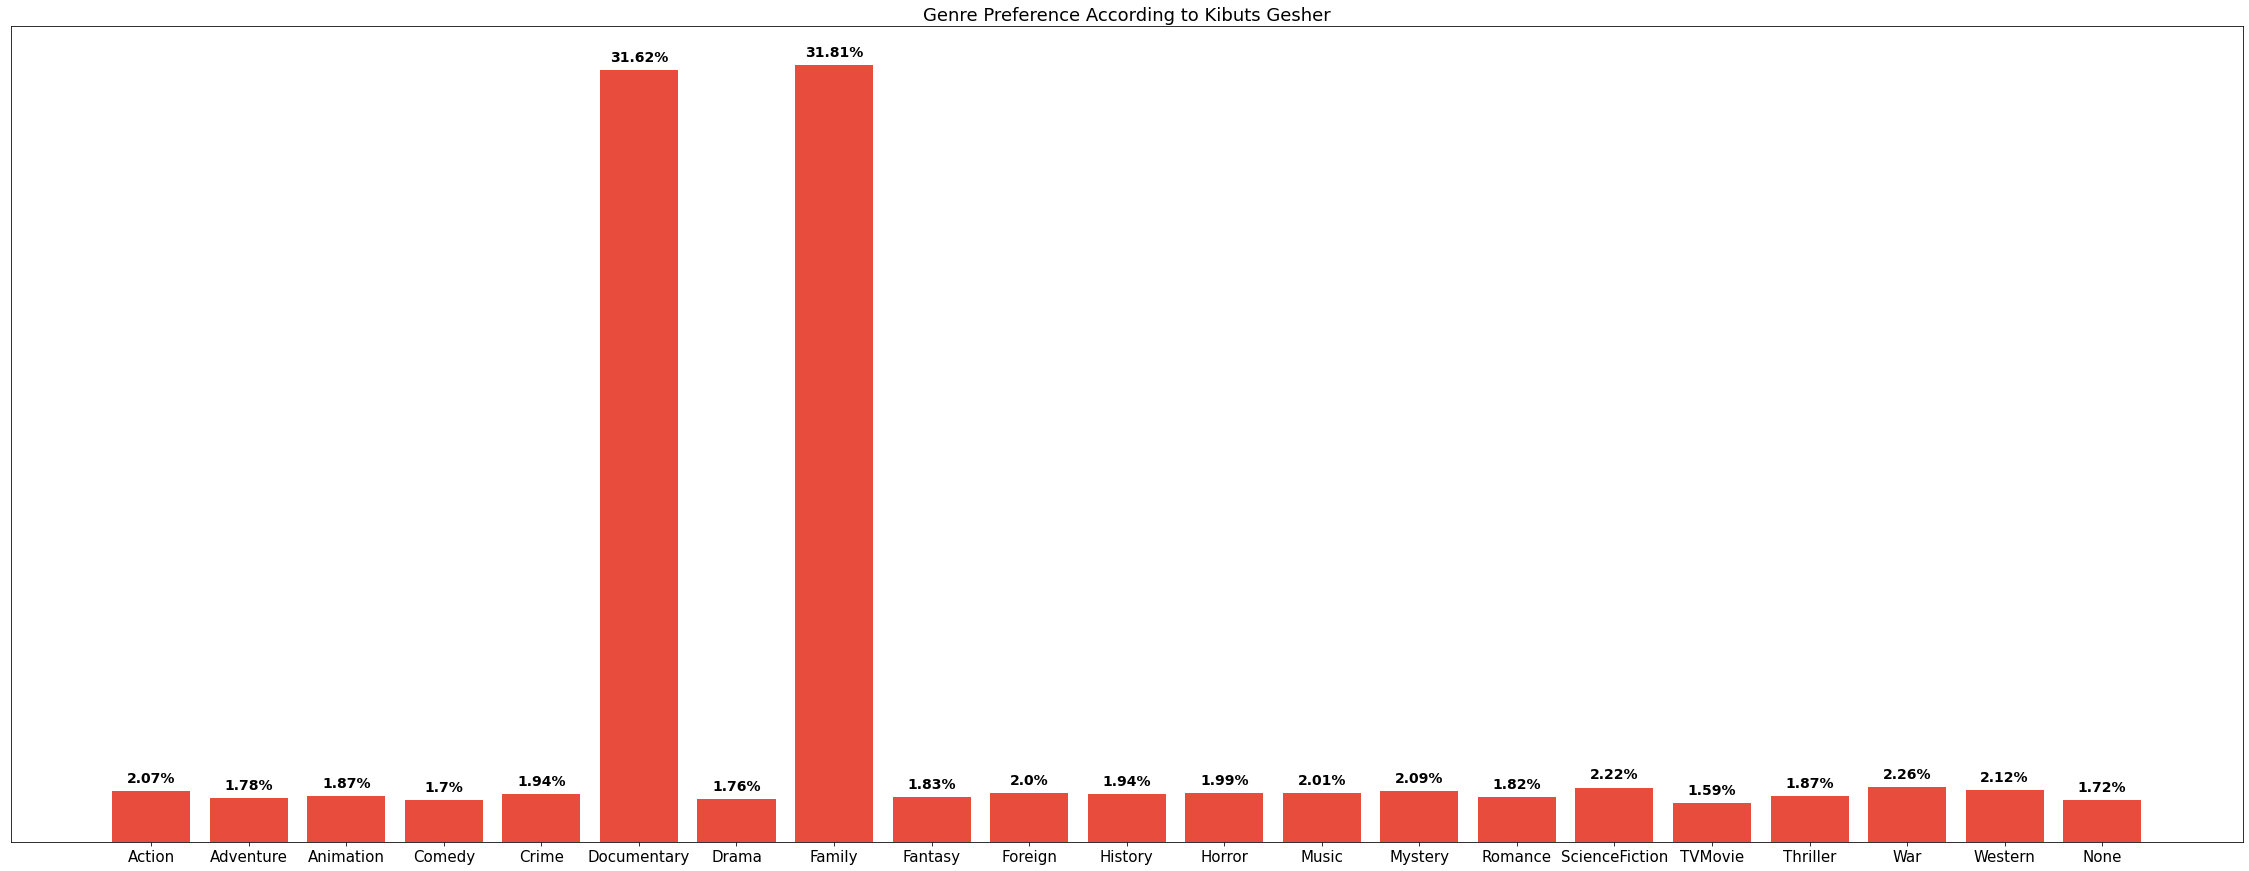

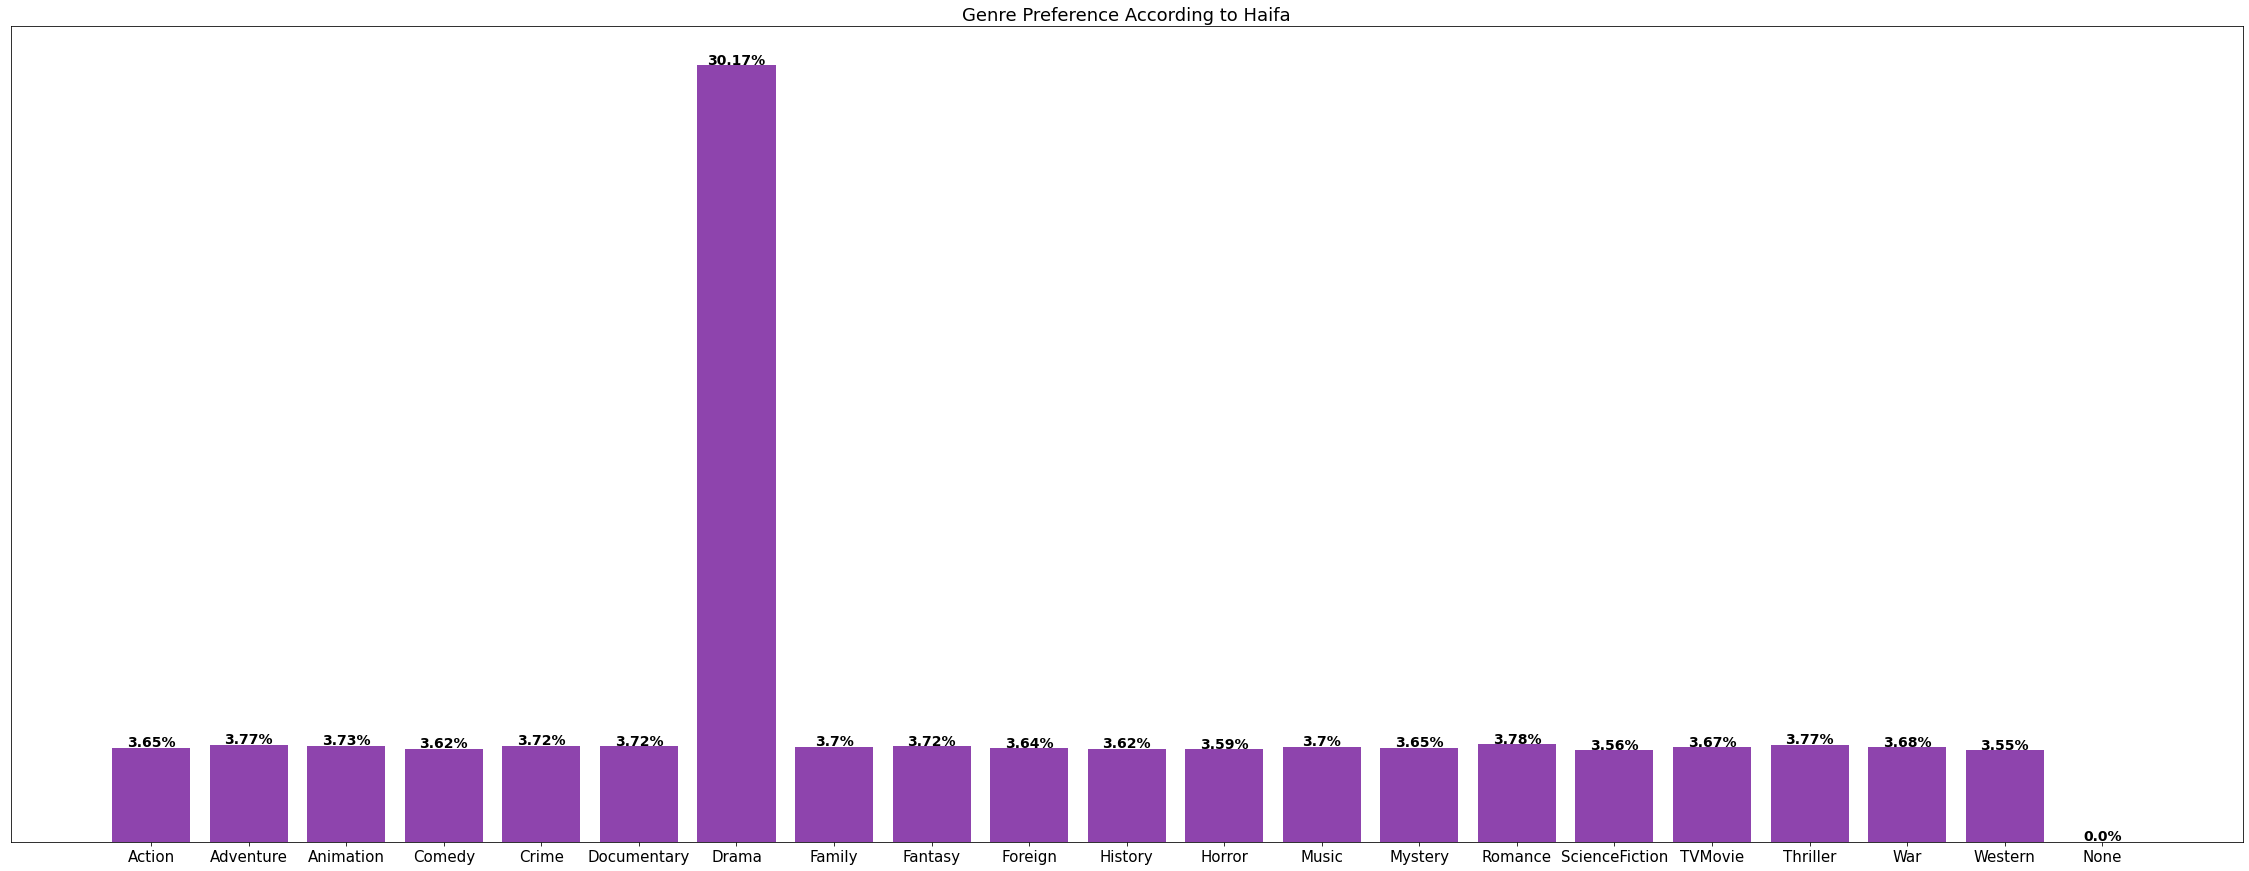

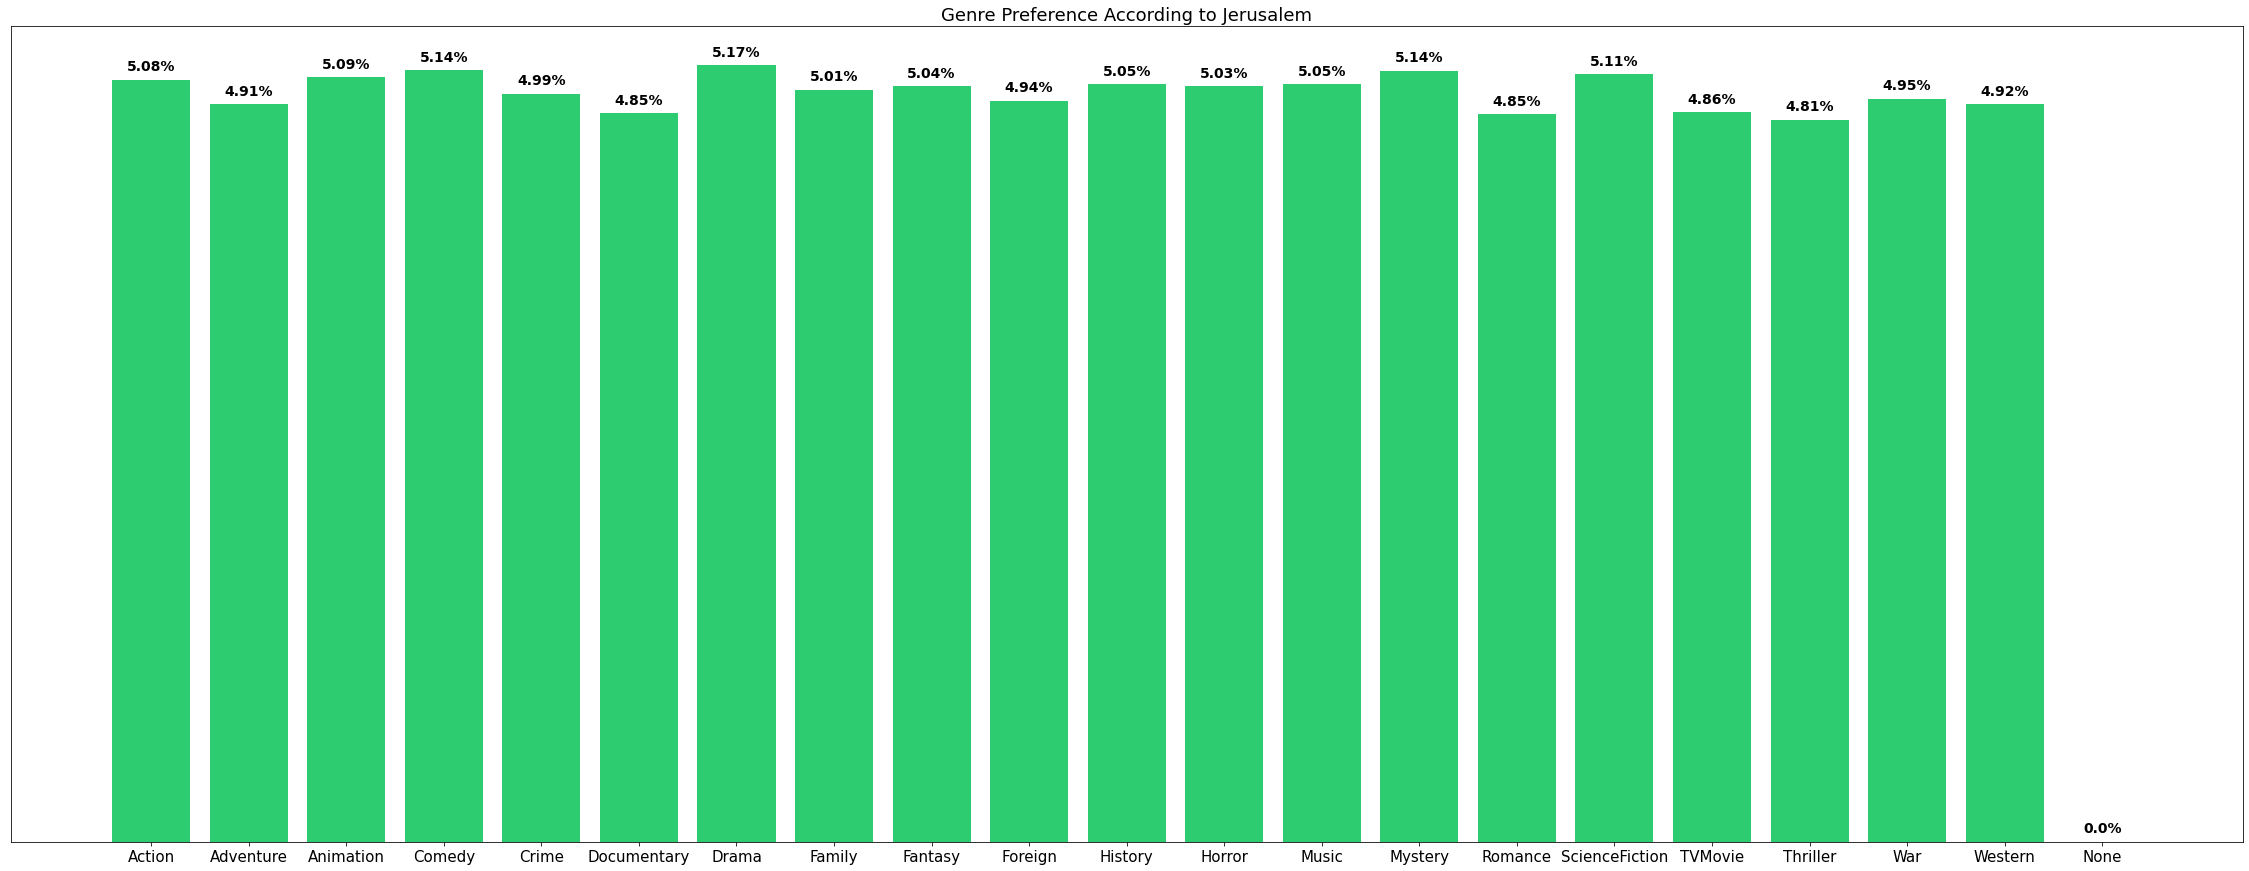

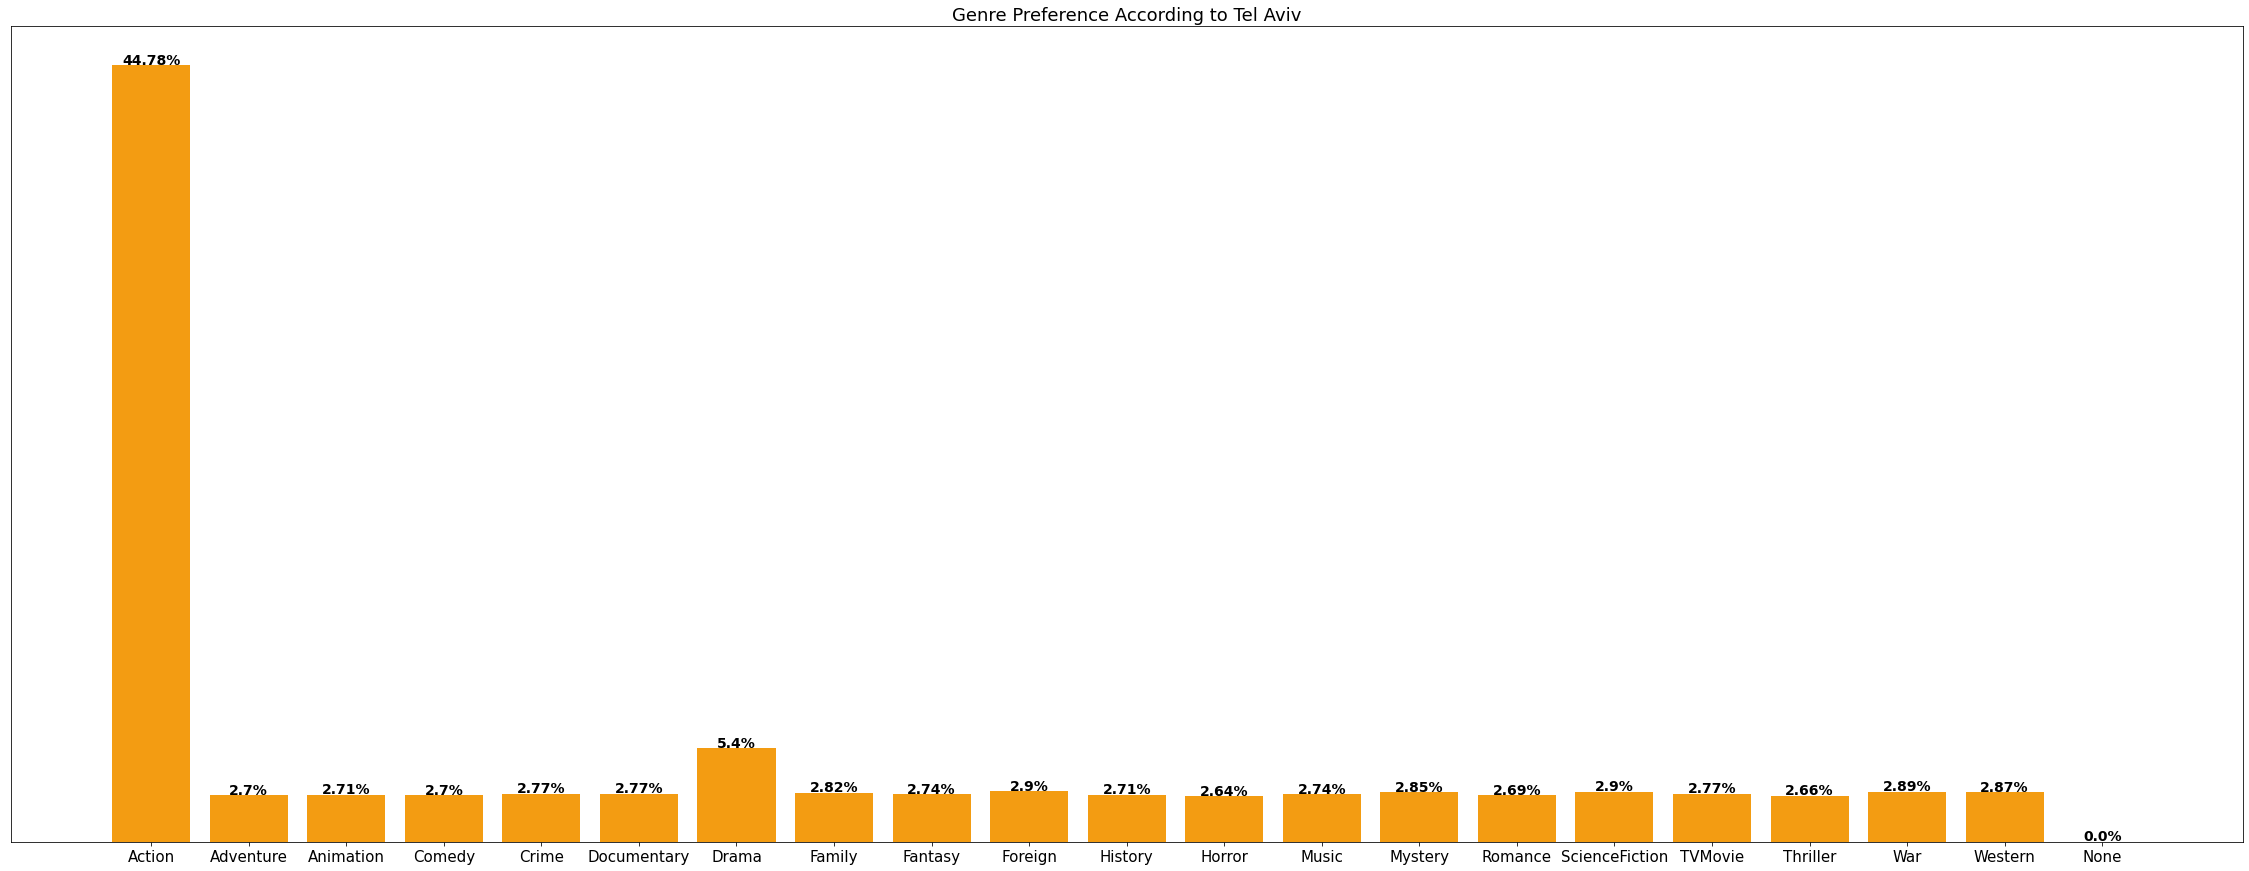

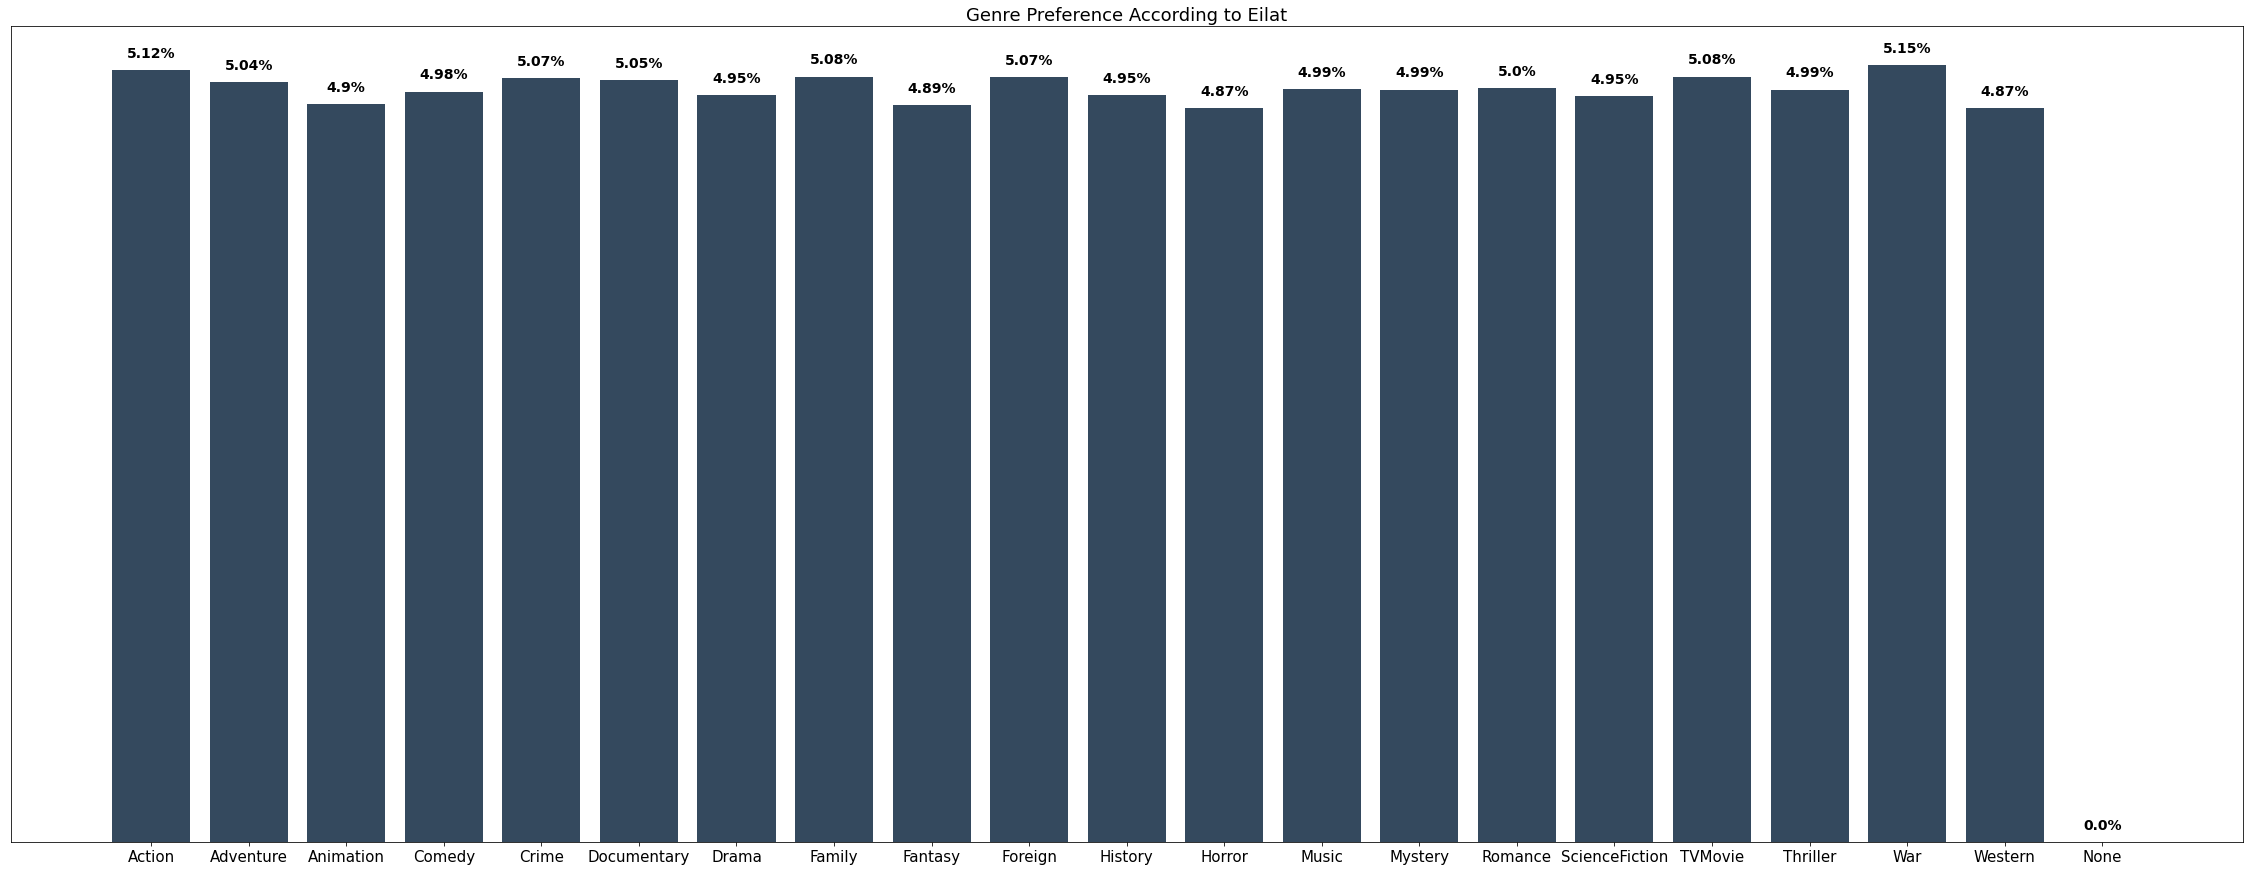

In [103]:
# Visualize results
counters = dict_genres
dicts = []
locations= []
for loc in counters:
  locations.append(loc)
  x = counters[loc]
  temp = [(key, x[key]) for key in x]
  temp.sort()

  # place the None counter at the end of list
  none = [val for val in temp if val[0] == 'None']
  temp.remove(none[0])
  temp += none
  
  dicts.append(dict(temp))


colors = ['#E74C3C', '#8E44AD', '#2ECC71', '#F39C12', '#34495E']
for i in range(len(counters)):
  create_bar(dicts[i], colors[i], f'Genre Preference According to {locations[i]}')

<center><i>figure 3.1, each bar plot shows the distribution of queries for a certain location, regarding the genre the query mentioned.</i>

##**Insight 3 conclusion**

By looking at figure 3.1 plots, we can clearly derive that certain locations show clear preference for certain genres, approving our assumption. 




*Kibuts Gesher*

Documentary and Family genres each accounting for slightly above 31% of total queries from users. The remaining ~ 38% is uniformly distributed between the 18 remaining genres.

*Haifa*

Drama accounts for slightly above 30% of total queries from users. The remaining ~ 70% is uniformly distributed between the 19 remaining genres.

*Jerusalem*

No preference found for users from Jerusalem.

*Tel Aviv*

Action accounts for slightly below 45% (!!!) of total queries from users. The remaining ~ 55% is uniformly distributed between the 19 remaining genres.

*Eilat*

No preference found for users from Eilat.

This information can influence our distributed design in question 3, for the cities showing preference towards certain genres.


Action might just be proven to be the language of Tel Aviv...

#**Insight 4: Connection between users location to the actors queried about**

##**4.1**

Assumption: Users prefer actors depending on the location of the user. 

According to Google, Morgan Freeman is the most liked actor in the U.S, on the other hand, down in Australia, the most liked actor is Chris Hemsworth.

Why would our data be any different?


In [88]:
df = credits.select('cast')
# creating list of all the unique genres in the data
df = df.withColumn("group_column", f.lit(1))
df = df.groupBy("group_column").agg(f.collect_list("cast"))
actors = df.withColumn("all_actors", f.flatten("collect_list(cast)")).select('all_actors')

actors_set = set(actors.collect()[0][0])
actors_set.remove('-')  # '-' represents a cell without genre value given (in movies)
print(f'Number of unique actors: {len(actors_set)}')
print()

# select both columns from queries
qu = queries.select('user_id')
# Inner join basen on user_id
join_df = qu.join(users,queries.user_id == users.user_id,"inner")

#count number of qureris per location
df = join_df.withColumn("ones", f.lit(1))
df = df.groupBy("user_location").sum('ones')
num_queries = df.withColumnRenamed('sum(ones)', 'Number of queries')
num_queries.show()

Number of unique actors: 202696

+-------------+-----------------+
|user_location|Number of queries|
+-------------+-----------------+
|Kibuts Gesher|             5288|
|        Haifa|            21652|
|    Jerusalem|            30873|
|     Tel Aviv|            24839|
|        Eilat|            17348|
+-------------+-----------------+



In [89]:
# find the most queried actors per location

def counter_list(val_list):
  # counts occurence of value in list, could have implemented with explode and groupe by using spark, but was very bad runtime. 
  return_dict = {}
  for val in val_list:
    if val in return_dict:
      return_dict[val] += 1
    else:
      return_dict[val] = 1
  sort_list = [(key, return_dict[key]) for key in return_dict]
  sort_list.sort(key= lambda x: x[1], reverse= True)

  return sort_list

# select 2 columns from queries
df = queries.select('user_id', 'actors')
# Inner join basen on user Id
df = df.join(users,df.user_id == users.user_id,"inner")

df_grouped = df.groupBy("user_location").agg(f.collect_list("actors"))
df_grouped = df_grouped.withColumn("genres_by_location", f.flatten("collect_list(actors)"))
data = df_grouped.collect()  # Each row is [location, _, list of all the actors queried by users from the location]

# use num_queries data
num_qu = num_queries.collect()
num_qu_dict = {}
for row in num_qu:
  num_qu_dict[row[0]] = row[1]


dict_genres = {}
for row in data:
  loc = row[0]
  dict_genres[loc] = counter_list(row[2])
  # print(loc_top_five[0][0])
  output = []
  for x in dict_genres[loc]:
    if x[1] > 10: # only interested in actors users searched more than 10 queries
      if x[0] != '':
        output.append(x)
      else:
        output.append(('None', x[1]))
  
  print(f'{loc}: {output}')
  print(f'Total queries from users in {loc}: {num_qu_dict[loc]}')
  print()




Kibuts Gesher: [('None', 2657)]
Total queries from users in Kibuts Gesher: 5288

Haifa: [('None', 10872)]
Total queries from users in Haifa: 21652

Jerusalem: [('TomHanks', 14700), ('JohnnyDepp', 14674), ('BradPitt', 14592), ('None', 1518)]
Total queries from users in Jerusalem: 30873

Tel Aviv: [('None', 12306)]
Total queries from users in Tel Aviv: 24839

Eilat: [('None', 17348)]
Total queries from users in Eilat: 17348



###**Insight 4.1 conclusion**

We found 2 interesting insights from looking for a prefrence for actors depending on users location. 

**The first insight:** users from jerusalem look for movies with Tom Hanks, Johnny Depp and Brad Pitt the majority of their queries. Each of the actors appearing in approximatley half of the queries. On the other hand in Tel Aviv, Haifa and Kibuts Gesher approximately half of the queries actors value was empty, with no preference.


**The second insight:** users from Eilat have no preference to actors, at all. all 17,348 queries had no actor value in them. 

##**4.2**

In [ ]:
!pip install pywaffle
from pywaffle import Waffle

Total queries from users in Kibuts Gesher: 5288
Top 5 queried directors for Kibuts Gesher: [('None', 5137)]
Top director / None queried (%): 97.14%



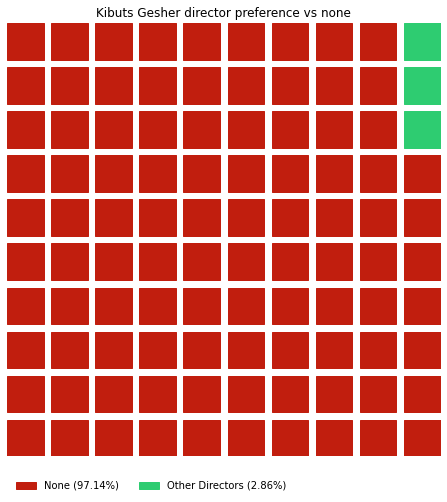


Total queries from users in Haifa: 21652
Top 5 queried directors for Haifa: [('None', 1752), ('JohnPogue', 16), ('BenShapiro', 16), ('CostaBotes', 16), ('GeorgeSluizer', 15)]
Top director / None queried (%): 8.09%



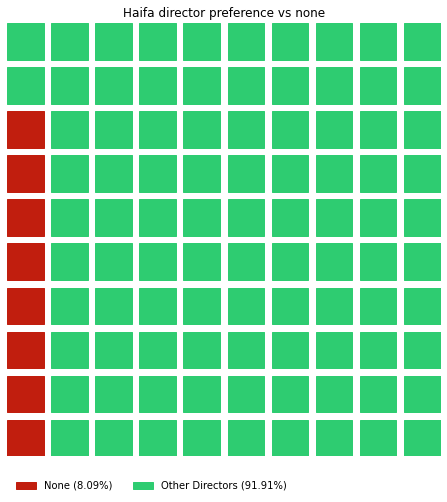


Total queries from users in Jerusalem: 30873
Top 5 queried directors for Jerusalem: [('None', 29907)]
Top director / None queried (%): 96.87%



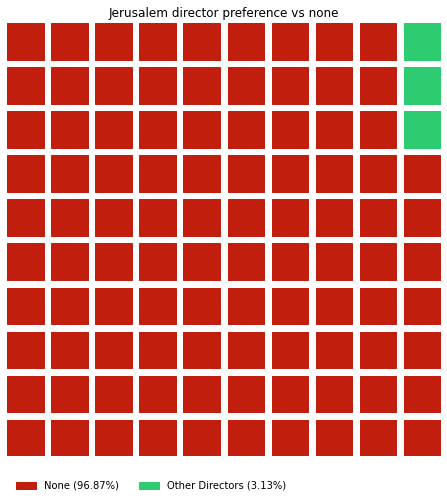


Total queries from users in Tel Aviv: 24839
Top 5 queried directors for Tel Aviv: [('None', 24076)]
Top director / None queried (%): 96.93%



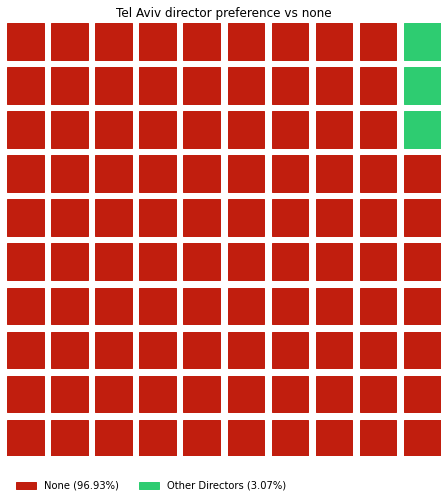


Total queries from users in Eilat: 17348
Top 5 queried directors for Eilat: [('None', 16816)]
Top director / None queried (%): 96.93%



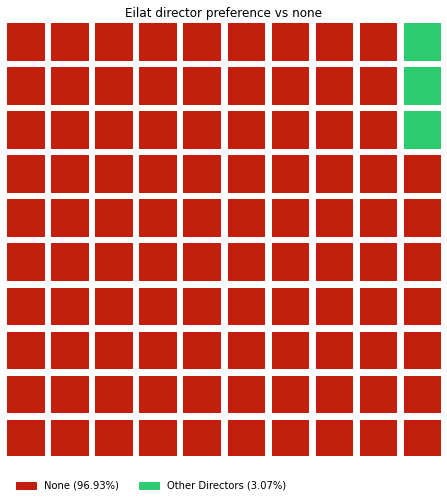

In [91]:
# find the most queried directors per location

def counter_list(val_list):
  # counts occurence of value in list, could have implemented with explode and groupe by using spark, but was very bad runtime. 
  return_dict = {}
  for val in val_list:
    if val in return_dict:
      return_dict[val] += 1
    else:
      return_dict[val] = 1
  sort_list = [(key, return_dict[key]) for key in return_dict]
  sort_list.sort(key= lambda x: x[1], reverse= True)

  return sort_list

# select required columns from queries data
df = queries.select('user_id', 'director')
# Inner join basen on user Id
df = df.join(users,df.user_id == users.user_id,"inner")

df_grouped = df.groupBy("user_location").agg(f.collect_list("director"))
df_grouped = df_grouped.withColumn("genres_by_location", f.flatten("collect_list(director)"))

data = df_grouped.collect()  # Each row is [location, _, list of all the directors queried by users from the location]

# use num_queries data from insight 4.1 above
num_qu = num_queries.collect()
num_qu_dict = {}
for row in num_qu:
  num_qu_dict[row[0]] = row[1]

results = []
dict_genres = {}
for row in data:
  loc = row[0]
  dict_genres[loc] = counter_list(row[2])
  output = []
  for x in dict_genres[loc]:
    if x[1] > 10: # only interested in directors users searched more than 10 queries
      if x[0] != '':
        output.append(x)
      else:
        output.append(('None', x[1]))
  
  x = round((output[0][1]/num_qu_dict[loc])*100, 2)
  results.append(('None' , x))
  results.append(('Other Directors' , round(100-x, 2)))
  
  print(f'Total queries from users in {loc}: {num_qu_dict[loc]}')
  print(f'Top 5 queried directors for {loc}: {output[:5]}')
  print(f'Top director / None queried (%): {x}%')
  print()

  data = dict(results)
  fig = plt.figure(
      figsize = (7, 7),
      FigureClass=Waffle, 
      rows=10, 
      values=data, 
      title={'label': f'{loc} director preference vs none', 'loc': 'center'},
      colors=['#C11E0E', '#2ECC71'], 
      labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
      legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.1), 'ncol': len(data), 'framealpha': 0}
  )
  plt.show()
  print()





###**Insight 4.2 conclusion**


These numbers are a surprise. (very simple to spot using the figures...)

For users from: 'Kibuts Gesher', 'Jerusalem', 'Tel Aviv', and 'Eilat', at least 96% of the queries had NO preference for a director!

Only 'Haifa' had a different user behaviour pattern, with only 8.09% of queries empty for the director input. 

This will help us design the data base next question, by knowing the majority of the time (96+ %) users from all sites except 'Haifa' dont query regarding the directors. Instead of holding vast amounts of data in every site, we can store the data in one place, where its needed most, and when other site need the data, they can request it (only 4% of the time).

#**Additional Insights**

##**Language**

In [92]:
lang = queries.select('lang')

number_qu = lang.count()


just_english_filter = f.udf(lambda x: 1 if x == ['English'] else 0, IntegerType())
contains_english = f.udf(lambda x: 1 if 'English' in x else 0, IntegerType())

lang = lang.withColumn("just_eng", just_english_filter('lang'))\
    .withColumn("with_eng", contains_english('lang'))


sum_correct_just_eng = lang.agg({'just_eng': 'sum'}).collect()[0][0]
sum_correct_contains_eng = lang.agg({'with_eng': 'sum'}).collect()[0][0]

print(f'Number of queries looking only for English: {sum_correct_just_eng}')
print(f'Number of queries containing English: {sum_correct_contains_eng}')
print(f'Number of queries: {number_qu}')
print()

print(f'Users looking only for English(%): {round(sum_correct_just_eng/number_qu, 4)*100}%')
print(f'Users looking for containing English(%): {round(sum_correct_contains_eng/number_qu, 4)*100}%')
print()
lang = queries.select('lang')
number_qu = lang.count()

df = lang.filter(f.size(lang['lang']) == 1)
one_lang = df.count()

df = lang.filter(f.size(lang['lang']) == 2)
two_lang = df.count()

df = lang.filter(f.size(lang['lang']) == 3)
three_lang = df.count()

df = lang.filter(f.size(lang['lang']) == 4)
four_lang = df.count()

df = lang.filter(f.size(lang['lang']) == 5)
five_lang = df.count()

print(f'Users looking for 1 language: {one_lang}, {round(one_lang/number_qu, 4)*100}%')
print(f'Users looking for 2 language: {two_lang}, {round(two_lang/number_qu, 4)*100}%')
print(f'Users looking for 3 language: {three_lang}, {round(three_lang/number_qu, 4)*100}%')
print(f'Users looking for 4 language: {four_lang}, {round(four_lang/number_qu, 4)*100}%')
print(f'Users looking for 5 language: {five_lang}, {round(five_lang/number_qu, 4)*100}%')
print()


num_movies = movies.count()
df = movies.select(movies.spoken_languages, f.array_contains(movies.spoken_languages, 'English')
    .alias("contains_english"))

not_in_english = df.filter(df.contains_english == False).count()

print(f'Number of movies: {num_movies}')
print(f'Number of movies not available in English: {not_in_english}, {round(not_in_english/num_movies, 4)*100}%')
print()

# Checking how many queries per location
df = queries.select('user_id')
df = df.join(users,df.user_id == users.user_id,"inner")
df = df.groupBy("user_location").count()
df.show()

# Checking how many users query just english per location
just_english_filter = f.udf(lambda x: 1 if x == ['English'] else 0, IntegerType())
df = queries.select('user_id', 'lang')
df = df.join(users,df.user_id == users.user_id,"inner")
df = df.withColumn("just_eng", just_english_filter('lang'))
df = df.groupBy("user_location").sum("just_eng")
df.show()

Number of queries looking only for English: 51766
Number of queries containing English: 100000
Number of queries: 100000

Users looking only for English(%): 51.77%
Users looking for containing English(%): 100.0%

Users looking for 1 language: 51766, 51.77%
Users looking for 2 language: 46177, 46.18%
Users looking for 3 language: 2057, 2.06%
Users looking for 4 language: 0, 0.0%
Users looking for 5 language: 0, 0.0%

Number of movies: 45460
Number of movies not available in English: 16725, 36.79%

+-------------+-----+
|user_location|count|
+-------------+-----+
|Kibuts Gesher| 5288|
|        Haifa|21652|
|    Jerusalem|30873|
|     Tel Aviv|24839|
|        Eilat|17348|
+-------------+-----+

+-------------+-------------+
|user_location|sum(just_eng)|
+-------------+-------------+
|Kibuts Gesher|         2616|
|        Haifa|        15235|
|    Jerusalem|         4283|
|     Tel Aviv|        17383|
|        Eilat|        12249|
+-------------+-------------+



###**Language insight conclusion**

The additional insight contributed to the design in the next question by using the information regarding the users which quried lang == English only. 51.77% of users queried only English, while there are 36.79% of movies in the data base without English as an available language. In addition, we checked how this number varied per location and found that the proportion varied from 13% to 71%.

##**Genres - Further analysis on insight 3 for design purposes**

### **Movies data analysis (with regards to genres)**

In [93]:
gen = movies.select('genres')


total = gen.count()
print(f"Total number of movies: {total}")
ones = gen.filter(f.size(gen['genres']) == 1).count() 
print(f'Number of movies with genre len == 1: {ones}, {round(ones/total*100, 2)}% of movies')

twos = gen.filter(f.size(gen['genres']) == 2).count() 
print(f'Number of movies with genre len == 2: {twos}, {round(twos/total*100, 2)}% of movies')

threes = gen.filter(f.size(gen['genres']) == 3).count() 
print(f'Number of movies with genre len == 3: {threes}, {round(threes/total*100, 2)}% of movies')

fours = gen.filter(f.size(gen['genres']) == 4).count() 
print(f'Number of movies with genre len == 4: {fours}, {round(fours/total*100, 2)}% of movies')
print()

df_1 = gen.filter(f.size(gen['genres']) == 1)
df_1 = df_1.select(df_1['*'], f.array_contains(df_1.genres, 'Action').alias("act"), f.array_contains(df_1.genres, 'Documentary').alias("doc"), f.array_contains(df_1.genres, 'Family').alias("fam"), f.array_contains(df_1.genres, 'Drama').alias("drama"))

print(f"Number of movies with 1 genre: {df_1.count()}")
num = df_1.filter(df_1.act == True).count()
print(f"Number of movies with 1 genre, genre = Action: {num}, {round(num/total*100, 2)}% of total queries")
num = df_1.filter(df_1.doc == True).count()
print(f"Number of movies with 1 genre, genre = Documentary: {num}, {round(num/total*100, 2)}% of total queries")
num = df_1.filter(df_1.fam == True).count()
print(f"Number of movies with 1 genre, genre = Family: {num}, {round(num/total*100, 2)}% of total queries")
num = df_1.filter(df_1.drama == True).count()
print(f"Number of movies with 1 genre, genre = Drama: {num}, {round(num/total*100, 2)}% of total queries")
print()

df = df_1.withColumn("group_column", f.lit(1))
df = df.groupBy("group_column").agg(f.collect_list("genres"))
single_genre = df.withColumn("single_genres", f.flatten("collect_list(genres)")).select('single_genres').collect()

count = Counter(single_genre[0][0])
count_list = [(key, count[key]) for key in count]
count_list.sort(key= lambda x: x[1], reverse=True)
print('Top 3 appearing genres in single genre movies:')

for i in range(3):
  print(count_list[i])
print()

df_2 = gen.filter(f.size(gen['genres']) == 2)
df_2 = df_2.select(df_2['*'], f.array_contains(df_2.genres, 'Action').alias("act"), f.array_contains(df_2.genres, 'Documentary').alias("doc"), f.array_contains(df_2.genres, 'Family').alias("fam"), f.array_contains(df_2.genres, 'Drama').alias("drama"))

print(f"Number of movies with 2 genre: {df_2.count()}")
num = df_2.filter(df_2.act == True).count()
print(f"Number of movies with 2 genres, genre = Action: {num}, {round(num/total*100, 2)}% of total movies")
num = df_2.filter(df_2.doc == True).count()
print(f"Number of movies with 2 genres, genre = Documentary: {num}, {round(num/total*100, 2)}% of total movies")
num = df_2.filter(df_2.fam == True).count()
print(f"Number of movies with 2 genres, genre = Family: {num}, {round(num/total*100, 2)}% of total movies")
num = df_2.filter(df_2.drama == True).count()
print(f"Number of movies with 2 genres, genre = Drama: {num}, {round(num/total*100, 2)}% of total movies")
print()

x = df_2.collect()
y = []
for row in x:
  if 'Drama' in row[0]:
    y += row[0]

print(f"Checking the genre pair with Drama: {len(set(y))} / 20")

Total number of movies: 45460
Number of movies with genre len == 1: 17001, 37.4% of movies
Number of movies with genre len == 2: 14479, 31.85% of movies
Number of movies with genre len == 3: 9584, 21.08% of movies
Number of movies with genre len == 4: 3378, 7.43% of movies

Number of movies with 1 genre: 17001
Number of movies with 1 genre, genre = Action: 278, 0.61% of total queries
Number of movies with 1 genre, genre = Documentary: 2723, 5.99% of total queries
Number of movies with 1 genre, genre = Family: 91, 0.2% of total queries
Number of movies with 1 genre, genre = Drama: 5000, 11.0% of total queries

Top 3 appearing genres in single genre movies:
('Drama', 5000)
('Comedy', 3621)
('Documentary', 2723)

Number of movies with 2 genre: 14479
Number of movies with 2 genres, genre = Action: 1566, 3.44% of total movies
Number of movies with 2 genres, genre = Documentary: 960, 2.11% of total movies
Number of movies with 2 genres, genre = Family: 888, 1.95% of total movies
Number of mo

**To conclude:**

Theres no convincing enough reason to divide the database based on user preference alone while the data from the genres in the movie data points to different conclusions. After all, we're dividing the movies data. 

The only actionable insight we have decided to use for the next part of the project is the fact that: 'Drama' appears as the only genre in 11% of all the movies. 'Drama' is the most popular genre search by Haifa users, ~30%, of all their queries. This will influence our design in the next part.  


### **Query data analysis (with regards to genres)**

The preference of users for certain genres depending on users location is clear. But, by looking at the queries, genres is a multi variable option. This is true also for the genres in the movie data. Meaning: the preference of users in a certain location to search mostly for a certain genre isnt enough to decide to use that genre as a feature by which we divide horizontally the data. The reason being - the genre alone might never appear alone in the query or movie. This thought caused us to further look into the genre data in the query table. 
We decided to include the research in the insights as an extra look into the users query behaviour. 

In [94]:
gen = queries.select('genres', 'user_id')
df_all = gen.join(users,gen.user_id == users.user_id,"inner")

# Kibuts Gesher further analysis
print('---------- Kibuts Gesher further analysis (genre queries) ----------')
df = df_all.filter(df_all['user_location'] == 'Kibuts Gesher')
total = df.count()
print(f'Number of queries from users located in Kibuts Gesher: {total}')
print()
ones = df.filter(f.size(df['genres']) == 1).count() 
print(f'Number of queries genre len == 1: {ones}')
df_1 = df.filter(f.size(df['genres']) == 1)
df_1 = df_1.select(df_1['*'], f.array_contains(df_1.genres, 'Documentary')
    .alias("doco"), f.array_contains(df_1.genres, 'Family')
    .alias("fam"))

num = df_1.filter(df_1.doco == True).count()
print(f"Number of genre query len == 1 and value == Documentary: {num}, {round(num/total*100, 2)}% of total queries")

num = df_1.filter(df_1.fam == True).count()
print(f"Number of genre query len == 1 and value == Family: {num}, {round(num/total*100, 2)}% of total queries")

print()

df_2 = df.filter(f.size(df['genres']) == 2)
twos = df_2.count() 
print(f'Number of queries genre len == 2: {twos}')
df_2 = df_2.select(df_2['*'], f.array_contains(df_2.genres, 'Documentary')
    .alias("doco"), f.array_contains(df_2.genres, 'Family')
    .alias("fam"))

num = df_2.filter(df_2.doco == True).count()
print(f"Number of genre query len == 2 and value == Documentary: {num}, {round(num/total*100, 2)}% of total queries")

num = df_2.filter(df_2.fam == True).count()
print(f"Number of genre query len == 2 and value == Family: {num}, {round(num/total*100, 2)}% of total queries")

print()

df_3 = df.filter(f.size(df['genres']) == 3)
threes = df_3.count() 
print(f'Number of queries genre len == 3: {threes}')
df_3 = df_3.select(df_3['*'], f.array_contains(df_3.genres, 'Documentary')
    .alias("doco"), f.array_contains(df_3.genres, 'Family')
    .alias("fam"))

num = df_3.filter(df_3.doco == True).count()
print(f"Number of genre query len == 3 and value == Documentary: {num}, {round(num/total*100, 2)}% of total queries")

num = df_3.filter(df_3.fam == True).count()
print(f"Number of genre query len == 3 and value == Family: {num}, {round(num/total*100, 2)}% of total queries")

---------- Kibuts Gesher further analysis (genre queries) ----------
Number of queries from users located in Kibuts Gesher: 5288

Number of queries genre len == 1: 2835
Number of genre query len == 1 and value == Documentary: 1301, 24.6% of total queries
Number of genre query len == 1 and value == Family: 1300, 24.58% of total queries

Number of queries genre len == 2: 1999
Number of genre query len == 2 and value == Documentary: 1045, 19.76% of total queries
Number of genre query len == 2 and value == Family: 1039, 19.65% of total queries

Number of queries genre len == 3: 454
Number of genre query len == 3 and value == Documentary: 245, 4.63% of total queries
Number of genre query len == 3 and value == Family: 268, 5.07% of total queries


In [95]:
# Tel Aviv further analysis
print()
print('---------- Tel Aviv further analysis (genre queries) ----------')
df = df_all.filter(df_all['user_location'] == 'Tel Aviv')
total = df.count()
print(f'Number of queries from users located in Tel Aviv: {total}')
print()
ones = df.filter(f.size(df['genres']) == 1).count() 
print(f'Number of queries genre len == 1: {ones}')
df_1 = df.filter(f.size(df['genres']) == 1)
df_1 = df_1.select(df_1['*'], f.array_contains(df_1.genres, 'Action').alias("act"))

num = df_1.filter(df_1.act == True).count()
print(f"Number of genre query len == 1 and value == Action: {num}, {round(num/total*100, 2)}% of total queries")
print()

df_2 = df.filter(f.size(df['genres']) == 2)
twos = df_2.count() 
print(f'Number of queries genre len == 2: {twos}')
df_2 = df_2.select(df_2['*'], f.array_contains(df_1.genres, 'Action').alias("act"))
num = df_2.filter(df_2.act == True).count()
print(f"Number of genre query len == 2 and value == Action: {num}, {round(num/total*100, 2)}% of total queries")
print()

x = df_2.collect()
res_list = []
for row in x:
  res_list.append(tuple(row[0]))
count = Counter(res_list)
count_above_800 = [(key, count[key]) for key in count if count[key] > 800]
print()
print('*****')
print('Query pairs repeated more than 800 times and one of the genres was Action:')
for tup in count_above_800:
  print(f'The pair: {tup[0]} was queried: {tup[1]} times')
print('*****')
print()

df_3 = df.filter(f.size(df['genres']) == 3)
threes = df_3.count() 
print(f'Number of queries genre len == 3: {threes}')
df_3 = df_3.select(df_3['*'], f.array_contains(df_1.genres, 'Action').alias("act"))

num = df_3.filter(df_3.act == True).count()
print(f"Number of genre query len == 3 and value == Action: {num}, {round(num/total*100, 2)}% of total queries")


---------- Tel Aviv further analysis (genre queries) ----------
Number of queries from users located in Tel Aviv: 24839

Number of queries genre len == 1: 5712
Number of genre query len == 1 and value == Action: 1180, 4.75% of total queries

Number of queries genre len == 2: 18238
Number of genre query len == 2 and value == Action: 18017, 72.54% of total queries


*****
Query pairs repeated more than 800 times and one of the genres was Action:
The pair: ('Action', 'Western') was queried: 988 times
The pair: ('Action', 'Documentary') was queried: 958 times
The pair: ('Action', 'Family') was queried: 955 times
The pair: ('Action', 'Thriller') was queried: 920 times
The pair: ('Action', 'Adventure') was queried: 918 times
The pair: ('Horror', 'Action') was queried: 882 times
The pair: ('Fantasy', 'Action') was queried: 939 times
The pair: ('Crime', 'Action') was queried: 930 times
The pair: ('Action', 'Music') was queried: 943 times
The pair: ('Action', 'ScienceFiction') was queried: 960

Tel Aviv users mostly query with 2 genres in the genre value. We found that 72% of these query contain 'Action', but, 'Action' appears with many other possible genres, therefore, we cant split the genres into disjoint groups for the purpose of a usefull fregmentation.

In [96]:
# Haifa further analysis
print()
print('---------- Haifa further analysis (genre queries)----------')
df = df_all.filter(df_all['user_location'] == 'Haifa')
total = df.count()
print(f'Number of queries from users located in Haifa: {total}')
print()
ones = df.filter(f.size(df['genres']) == 1).count() 
print(f'Number of queries genre len == 1: {ones}')
df_1 = df.filter(f.size(df['genres']) == 1)
df_1 = df_1.select(df_1['*'], f.array_contains(df_1.genres, 'Drama').alias("drama"))

num = df_1.filter(df_1.drama == True).count()
print(f"Number of genre query len == 1 and value == Drama: {num}, {round(num/total*100, 2)}% of total queries")
print()

df_2 = df.filter(f.size(df['genres']) == 2)
twos = df_2.count() 
print(f'Number of queries genre len == 2: {twos}')
df_2 = df_2.select(df_2['*'], f.array_contains(df_1.genres, 'Drama').alias("drama"))
num = df_2.filter(df_2.drama == True).count()
print(f"Number of genre query len == 2 and value == Drama: {num}, {round(num/total*100, 2)}% of total queries")
print()

df_3 = df.filter(f.size(df['genres']) == 3)
threes = df_3.count() 
print(f'Number of queries genre len == 3: {threes}')
df_3 = df_3.select(df_3['*'], f.array_contains(df_1.genres, 'Drama').alias("drama"))

num = df_3.filter(df_3.drama == True).count()
print(f"Number of genre query len == 3 and value == Drama: {num}, {round(num/total*100, 2)}% of total queries")

x = df_3.collect()
res_list = []
y = []
for row in x:
  res_list.append(tuple(row[0]))
  if 'Drama' in row[0]:  # only if Drama is one of the genres in query - add to y
    y += (row[0])

distinct_genres = len(set(y))
print()
print('*****')
print(f"The number of unique genres in the queries where len(genre) == 3 and drama was part of the query: {distinct_genres}")
print('*****')


---------- Haifa further analysis (genre queries)----------
Number of queries from users located in Haifa: 21652

Number of queries genre len == 1: 0
Number of genre query len == 1 and value == Drama: 0, 0.0% of total queries

Number of queries genre len == 2: 6077
Number of genre query len == 2 and value == Drama: 2189, 10.11% of total queries

Number of queries genre len == 3: 15575
Number of genre query len == 3 and value == Drama: 15575, 71.93% of total queries

*****
The number of unique genres in the queries where len(genre) == 3 and drama was part of the query: 20
*****


Haifa users mostly query with 3 genres in the genre value. We found that 71% of these query contain 'Drama', but, 'Drama' is with all the other possible genres, therefore, we cant split the genres into disjoint groups for the purpose of a usefull fregmentation.

In [97]:
# Eilat further analysis
print()
print('---------- Eilat further analysis (genre queries)----------')
df = df_all.filter(df_all['user_location'] == 'Eilat')
total = df.count()
print(f'Number of queries from users located in Eilat: {total}')
print()
ones = df.filter(f.size(df['genres']) == 1).count() 
print(f'Number of queries genre len == 1: {ones}, {round((ones/total)*100, 2)}% of total')

twos = df.filter(f.size(df['genres']) == 2).count() 
print(f'Number of queries genre len == 2: {twos}, {round((twos/total)*100, 2)}% of total')


---------- Eilat further analysis (genre queries)----------
Number of queries from users located in Eilat: 17348

Number of queries genre len == 1: 0, 0.0% of total
Number of queries genre len == 2: 17348, 100.0% of total


All users from Eilat query the data using 2 genres, we also checked if these are 2 dijoint groups of genres so that we might be able to divide the data for Eilat using this insight, unfortunetly, they are not disjoint groups. 

In [98]:
# Jerusalem further analysis
print()
print('---------- Jerusalem further analysis (genre queries)----------')
df = df_all.filter(df_all['user_location'] == 'Jerusalem')
total = df.count()
print(f'Number of queries from users located in Jerusalem: {total}')
print()
ones = df.filter(f.size(df['genres']) == 1).count() 
print(f'Number of queries genre len == 1: {ones}, {round((ones/total)*100, 2)}% of total')

twos = df.filter(f.size(df['genres']) == 2).count() 
print(f'Number of queries genre len == 2: {twos}, {round((twos/total)*100, 2)}% of total')

threes = df.filter(f.size(df['genres']) == 3).count() 
print(f'Number of queries genre len == 3: {threes}, {round((threes/total)*100, 2)}% of total')



---------- Jerusalem further analysis (genre queries)----------
Number of queries from users located in Jerusalem: 30873

Number of queries genre len == 1: 16068, 52.05% of total
Number of queries genre len == 2: 12268, 39.74% of total
Number of queries genre len == 3: 2537, 8.22% of total


Jerusalem users showed no preference to a certain genre, therfore, we cannot use the 52% of the single genre queries behaviour for any specific fregmentation.